# Introducción

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

Para este proyecto, realizaré un análisis exploratorio de datos que tendrá como objetivo desarrollar una nueva función que proporcione a los supervisores información crucial sobre el rendimiento de sus operadores, permitiéndoles asi, tomar decisiones informadas para mejorar la eficiencia del servicio.

In [1]:
# Cargamos todas las librerías
import pandas as pd
import numpy as np
import math as mt 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
import plotly.express as px
from scipy import stats as st
from math import factorial
from scipy.stats import chi2_contingency, spearmanr, shapiro, ttest_ind, mannwhitneyu
from sklearn.preprocessing import MinMaxScaler

# Leemos los archivos CSV y los asignamos a variables
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
td = pd.read_csv('/datasets/telecom_dataset_us.csv')

In [2]:
# hechamos un vistazo rapido a CLients

clients.info()
print()
print(clients.head())
print()
print(clients.isna().sum())
print()
print(clients.describe())
print()
# Encontramos duplicados considerando todas las columnas
print("Valores duplicados: ", clients.duplicated(subset=clients.columns, keep=False).sum())  # keep=False marca todos los duplicados


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16

user_id        0
tariff_plan    0
date_start     0
dtype: int64

             user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000

Valores duplicados:  0


deacuerdo al vistazo rápido de nuestro dataframe Clients, podemos observar que no tenemos valores ausentes ni duplicados, sin embargo, para cuestiones de análisis en los siguientes pasos, debemos cambiar el tipo de datos para la columna 'date_start' ya que se encuentra en tipo Objeto

In [3]:
# hechamos un vistazo rapido al otro dataframe, Telecom_dataset (td)

td.info()
print()
print(td.head())
print()
print(td.isna().sum())
print()
print(td.describe())
print()
# Encontramos duplicados considerando todas las columnas
print("Valores duplicados: ", td.duplicated(subset=td.columns, keep=False).sum())  # keep=False marca todos los duplicado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out    

deacuerdo al vistazo rápido de nuestro dataframe rd (telecom_database), podemos observar que tenemos valores ausentes en algunas columnas asi como duplicados, para cuestiones de análisis en los siguientes pasos, debemos cambiar el tipo de datos para la columna 'datet' ya que se encuentra en tipo Objeto y analizar si es factible eliminar los valores duplicados y/o ausentes ya que representan un porcentaje considerable de nuestro analisis y podria sesgar nuestros datos.

# Definir el objetivo

**- ¿Qué queremos conseguir con esta información y por qué?**

El objetivo de nuestro análisis es desarrollar un sistema para identificar operadores ineficaces con el cual, se busca mejorar la calidad del servicio, reducir la pérdida de clientes y optimizar la asignación de recursos.

**- ¿A quién le interesa lo que realizaremos con este análisis?**

Nuestro enfoque de interés principal es para los supervisores y gerencia de la empresa CallMeMaybe, los cuales gracias a la ayuda del increible equipo de analistas de Datos, utilizarán esta información para la gestión del rendimiento, la formación de operadores y la planificación de la capacidad. Los cuales se beneficiarán de una mayor eficiencia operativa y satisfacción del cliente.

**- ¿Qué decisiones se tomarán de acuerdo a mi análisis?**

Se tomarán decisiones sobre la capacitación adicional de los operadores, la reasignación de tareas, la optimización de los flujos de trabajo e incluso posibles medidas disciplinarias o de incentivos. El análisis también puede ayudar a identificar problemas sistémicos que contribuyen a la ineficiencia.

# Proponer hipótesis

Basándonos en la información con la que contamos sobre los datos de la empresa CallMeMaybe, se sugiere la siguiente hipótesis:

H0: La tasa de llamadas perdidas no está correlacionada con el tiempo de espera.

H1: Existe una correlación positiva.

Para esta hipótesis, se propone usar el método de correlación de Spearman, ya que esta mide la fuerza y la dirección de la asociación monotónica entre dos variables. Es decir, significa que a medida que una variable aumenta, la otra tiende a aumentar (o disminuir), pero no necesariamente a un ritmo constante. Es no paramétrica, lo que significa que no asume una distribución normal de los datos.

Este metodo nos dará un coeficiente de correlación entre -1 y 1. El cual nos dice que, on valor cercano a 1 indica una fuerte correlación positiva osease, para nuestro analisis a mayor tiempo de espera, mayor tasa de llamadas perdidas. Y un valor cercano a -1 indica una fuerte correlación negativa, y un valor cercano a 0 indica una correlación débil o nula.

# Convertir las hipótesis en un plan de acción claro

Una vez planteada la hipotesis, voy a realizar un plan de accion para poder llegar a la hipotesis y conclusiones.
Realizare lo siguiente:
    
- **Convertir tipo de datos**: como se mencionó anteriormente, las columnas 'date_start' y 'date' están en tipo object, lo cual para el análisis próximo, necesitaremos en formato fecha.

- **Eliminar y rellenar valores ausentes**: se necesita hacer un analisis de los valores ausentes para operator_id, ya que cuenta con 8172 valores ausentes. La columna 'internal' contiene solo 117 datos ausentes, al ser tan pocos (de un total de 53902) eliminarlos parece la opcion mas directa

- se creará una nueva variable que contendrá toda la info de ambos dataframes (uniendolos con merge)

- **analizar duplicados**: ver si los valores duplicados son realmente errores de datos y proceder a eliminarlos o conservarlos

- calcular tiempo de espera y tasa de perdidas

- crear histogramas y graficas para visualizacion de datos mas claramente 

- prueba de hipotesis

In [4]:
# Convertir a datetime
clients['date_start'] = pd.to_datetime(clients['date_start'])
td['date'] = pd.to_datetime(td['date'])

#llenamos los valores ausentes y transformamos la columna 'operator_id' a formato string, ya que son IDs
td['operator_id']=td['operator_id'].fillna("unknown")
td['operator_id'] = td['operator_id'].astype(str).str.split('.').str[0]

# Eliminar filas con valores faltantes en 'internal' (td)
td.dropna(subset=['internal'], inplace=True)

td.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53785 non-null  int64                                
 1   date                 53785 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53785 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          53785 non-null  object                               
 5   is_missed_call       53785 non-null  bool                                 
 6   calls_count          53785 non-null  int64                                
 7   call_duration        53785 non-null  int64                                
 8   total_call_duration  53785 non-null  int64                                
dtypes: bool

In [5]:
# Identificamos todos los duplicados en td
td_duplicates = td[td.duplicated(keep=False)]

# Ordenamos por columnas clave para mejor visualización
td_duplicates = td_duplicates.sort_values(by=['user_id', 'date', 'direction'])

# Inspeccionar duplicados
print(td_duplicates.head(10))
print()

#agrupamos los duplicados por 'user_id', 'date' y 'direction' y los contamos
duplicates_count = td_duplicates.groupby(['user_id', 'date', 'direction'])['calls_count'].count()
print(duplicates_count)

    user_id                      date direction internal operator_id  \
6    166377 2019-08-05 00:00:00+03:00       out    False      880020   
8    166377 2019-08-05 00:00:00+03:00       out    False      880020   
27   166377 2019-08-12 00:00:00+03:00        in    False     unknown   
28   166377 2019-08-12 00:00:00+03:00        in    False     unknown   
38   166377 2019-08-14 00:00:00+03:00        in    False     unknown   
45   166377 2019-08-14 00:00:00+03:00        in    False     unknown   
43   166377 2019-08-14 00:00:00+03:00       out    False      880026   
44   166377 2019-08-14 00:00:00+03:00       out    False      880026   
46   166377 2019-08-15 00:00:00+03:00       out    False      880026   
51   166377 2019-08-15 00:00:00+03:00       out    False      880026   

    is_missed_call  calls_count  call_duration  total_call_duration  
6             True            8              0                   50  
8             True            8              0                   50

Podemos observar que las filas duplicadas parecen registros exactos duplicados en nuestros datos, por lo cual vamos a proceder a eliminarlos para evitar sesgos en nuestros resultados y analisis

In [6]:
# Eliminamos duplicados idénticos
td.drop_duplicates(inplace=True)

#comprobamos los duplicados
print("Valores duplicados: ", td.duplicated(subset=td.columns, keep=False).sum())  # keep=False marca todos los duplicado

Valores duplicados:  0


Una vez que terminamos de limpiar nuestro Dataframe 'td', vamos a crear una columna nueva para el tiempo de espera de las llamadas y posteriormente unir ambos dataframes

In [7]:
# Creamos una columna nueva llamada 'waiting_time'
td['waiting_time'] = td['total_call_duration'] - td['call_duration']

# Unimos los dataframes (Left join utilizando 'td' como tabla izquierda)
telecom_total = td.merge(clients, on='user_id', how='left')

print(telecom_total.head())

   user_id                      date direction internal operator_id  \
0   166377 2019-08-04 00:00:00+03:00        in    False     unknown   
1   166377 2019-08-05 00:00:00+03:00       out     True      880022   
2   166377 2019-08-05 00:00:00+03:00       out     True      880020   
3   166377 2019-08-05 00:00:00+03:00       out     True      880020   
4   166377 2019-08-05 00:00:00+03:00       out    False      880022   

   is_missed_call  calls_count  call_duration  total_call_duration  \
0            True            2              0                    4   
1            True            3              0                    5   
2            True            1              0                    1   
3           False            1             10                   18   
4            True            3              0                   25   

   waiting_time tariff_plan date_start  
0             4           B 2019-08-01  
1             5           B 2019-08-01  
2             1           B 2

In [8]:
# Calculamos la tasa de llamadas perdidas
missed_calls = telecom_total.groupby('operator_id')['is_missed_call'].sum()
total_calls = telecom_total.groupby('operator_id')['calls_count'].sum()
missed_call_rate = missed_calls / total_calls
missed_call_rate = missed_call_rate.reset_index().rename(columns={0:'missed_call_rate'})

print(missed_call_rate)

# Unimos el dataframe con la tasa de llamadas perdidas 
telecom_total = pd.merge(telecom_total,missed_call_rate, on = 'operator_id', how = 'left')
print()
print(telecom_total.head(10))


     operator_id  missed_call_rate
0         879896          0.050538
1         879898          0.012172
2         880020          0.133333
3         880022          0.147208
4         880026          0.038978
...          ...               ...
1088      972412          0.032787
1089      972460          0.058824
1090      973120          0.333333
1091      973286          0.000000
1092     unknown          0.069809

[1093 rows x 2 columns]

   user_id                      date direction internal operator_id  \
0   166377 2019-08-04 00:00:00+03:00        in    False     unknown   
1   166377 2019-08-05 00:00:00+03:00       out     True      880022   
2   166377 2019-08-05 00:00:00+03:00       out     True      880020   
3   166377 2019-08-05 00:00:00+03:00       out     True      880020   
4   166377 2019-08-05 00:00:00+03:00       out    False      880022   
5   166377 2019-08-05 00:00:00+03:00       out    False      880020   
6   166377 2019-08-05 00:00:00+03:00       out    False  

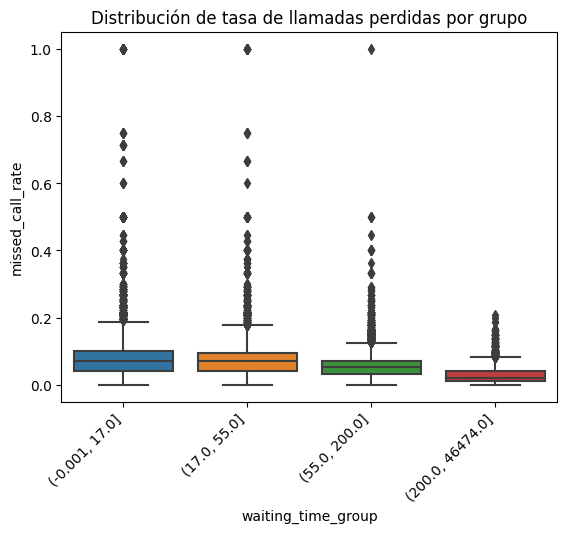

In [9]:
# Dividimos waiting_time en cuartiles 
telecom_total['waiting_time_group'] = pd.qcut(telecom_total['waiting_time'], 4)

sns.boxplot(x='waiting_time_group', y='missed_call_rate', data=telecom_total)
plt.xticks(rotation=45, ha='right')
plt.title("Distribución de tasa de llamadas perdidas por grupo")
plt.show()

Esta gráfica de Boxplot muestra la distribución de la tasa de llamadas perdidas para diferentes grupos de tiempo de espera. Cada caja representa un cuartil de los datos de tiempo de espera. Las medianas de la tasa de llamadas perdidas son bastante similares en todos los grupos de tiempo de espera, lo que podemos interpretar como que no hay una gran diferencia en la tendencia central de la tasa de llamadas perdidas entre los diferentes cuartiles de tiempo de espera. Tambien podemos denotar que hay bastantes valores atípicos en los primeros tres cuartiles de tiempo de espera. Estas representan operadores con tasas de llamadas perdidas inusualmente altas para su grupo de tiempo de espera. Esto nos sugiere que puede haber otros factores además del tiempo de espera que influyen en la tasa de llamadas perdidas, especialmente para tiempos de espera bajos y medios.

# Prueba de hipótesis

probamos la hipotesis que planteamos anteriormente:

**H0**: La tasa de llamadas perdidas no está correlacionada con el tiempo de espera.

**H1**: Existe una correlación positiva.

proponemos el nivel de significancia en 0.5 


In [10]:
correlation, pvalue = spearmanr(telecom_total['waiting_time'], telecom_total['missed_call_rate'])

print(f"Coeficiente de correlación de Spearman: {correlation}")
print(f"Valor p: {pvalue}")

alpha = 0.05  # Nivel de significancia

if pvalue < alpha:
    print("Se rechaza la hipótesis nula.")
    if correlation > 0:
        print("Existe una correlación positiva significativa entre el tiempo de espera y la tasa de llamadas perdidas.")
    elif correlation < 0:
        print("Existe una correlación negativa significativa entre el tiempo de espera y la tasa de llamadas perdidas.")
        
else:
    print("No se rechaza la hipótesis nula. No hay suficiente evidencia para concluir que existe una correlación entre el tiempo de espera y la tasa de llamadas perdidas.")

Coeficiente de correlación de Spearman: -0.4344993945954758
Valor p: 0.0
Se rechaza la hipótesis nula.
Existe una correlación negativa significativa entre el tiempo de espera y la tasa de llamadas perdidas.


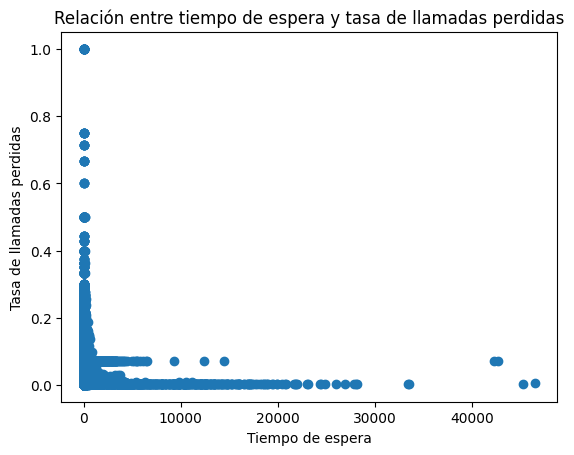

In [11]:
#gráfica para visualizar la relación
plt.scatter(telecom_total['waiting_time'], telecom_total['missed_call_rate'])
plt.xlabel("Tiempo de espera")
plt.ylabel("Tasa de llamadas perdidas")
plt.title("Relación entre tiempo de espera y tasa de llamadas perdidas")
plt.show()

Deacuerdo a nuestro analisis y prueba de hipotesis, la prueba de Spearman muestra una correlación negativa moderadamente fuerte del -0.43 y estadísticamente significativa entre el tiempo de espera y la tasa de llamadas perdidas. 
Esto nos dice que, a medida que aumenta el tiempo de espera, la tasa de llamadas perdidas disminuye.

## se propone otra hipótesis para analizar mas a fondo otra información relevante

Hipótesis:

**H0**: No hay diferencia en el tiempo de espera entre operadores eficientes e ineficientes.

**H1**: Hay una diferencia en el tiempo de espera entre operadores eficientes e ineficientes.

In [12]:
# Definimos umbrales individuales, percentil 75 para eficiencia
missed_call_th = telecom_total['missed_call_rate'].quantile(0.75)
waiting_time_th = telecom_total['waiting_time'].quantile(0.75)

# Estandarizamos  missed_call_rate y waiting_time
scaler = MinMaxScaler()
telecom_total['missed_call_rate_std'] = scaler.fit_transform(telecom_total[['missed_call_rate']])
telecom_total['waiting_time_std'] = scaler.fit_transform(telecom_total[['waiting_time']])

#ajustamos el peso a .7 para dar un margen mas estricto a eficiencia
w1 = 0.7  # Peso para missed_call_rate
w2 = 0.7  # Peso para waiting_time

telecom_total['efficiency_index'] = w1 * (1 - telecom_total['missed_call_rate_std']) + w2 * (1- telecom_total['waiting_time_std'])

#Clasificamos operadores según el indice con percentil 25
efficiency_threshold = telecom_total['efficiency_index'].quantile(0.25)
telecom_total['operator_efficiency'] = np.where(telecom_total['efficiency_index'] >= efficiency_threshold, 'Efficient', 'Inefficient')
print(telecom_total.groupby('operator_efficiency')['operator_id'].count())
print(telecom_total.head())

operator_efficiency
Efficient      36669
Inefficient    12223
Name: operator_id, dtype: int64
   user_id                      date direction internal operator_id  \
0   166377 2019-08-04 00:00:00+03:00        in    False     unknown   
1   166377 2019-08-05 00:00:00+03:00       out     True      880022   
2   166377 2019-08-05 00:00:00+03:00       out     True      880020   
3   166377 2019-08-05 00:00:00+03:00       out     True      880020   
4   166377 2019-08-05 00:00:00+03:00       out    False      880022   

   is_missed_call  calls_count  call_duration  total_call_duration  \
0            True            2              0                    4   
1            True            3              0                    5   
2            True            1              0                    1   
3           False            1             10                   18   
4            True            3              0                   25   

   waiting_time tariff_plan date_start  missed_call_rate w

Prueba U de Mann-Whitney: p-value = 0.0
Se rechaza la hipotesis nula, hay diferencia entre operadores eficientes e ineficientes


/opt/conda/envs/python3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


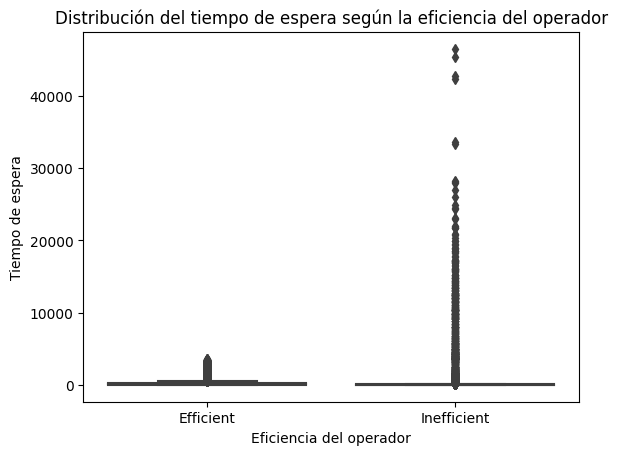

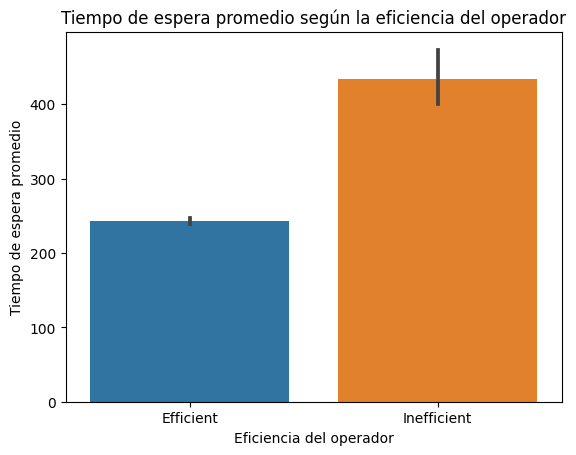

In [13]:
#Si p-value < 0.05 entonces no hay normalidad y no puedo usar t-test

efficient_wt= telecom_total[telecom_total['operator_efficiency'] == 'Efficient']['waiting_time'].dropna()
inefficient_wt = telecom_total[telecom_total['operator_efficiency'] == 'Inefficient']['waiting_time'].dropna()


test_efficient = shapiro(efficient_wt)
test_inefficient = shapiro(inefficient_wt)

# si alguno de los grupos no es normal, se hace test no parametrico
if test_efficient.pvalue <0.05 or test_inefficient.pvalue < 0.05: 

    statistic, p_value = mannwhitneyu(telecom_total[telecom_total['operator_efficiency'] == 'Efficient']['waiting_time'], telecom_total[telecom_total['operator_efficiency'] == 'Inefficient']['waiting_time'], alternative='two-sided')
    print(f"Prueba U de Mann-Whitney: p-value = {p_value}")

    if p_value< 0.05:

        print('Se rechaza la hipotesis nula, hay diferencia entre operadores eficientes e ineficientes')
    else:
        print('NO se rechaza la hipotesis nula')

else:

    statistic, p_value = ttest_ind(efficient_wt, inefficient_wt, equal_var=False, nan_policy='omit')
    print(f"Prueba t: p-value = {p_value}")

    if p_value< 0.05:

        print('Se rechaza la hipotesis nula, por lo tanto hay diferencia entre operadores eficientes e ineficientes en cuanto a waiting_time, usando t-test')

    else:
        print('NO se rechaza la hipotesis nula')
        

sns.boxplot(y='waiting_time', x='operator_efficiency', data=telecom_total)
plt.xlabel("Eficiencia del operador")
plt.ylabel("Tiempo de espera")
plt.title("Distribución del tiempo de espera según la eficiencia del operador")
plt.show()

# Por defecto usa la media
sns.barplot(x='operator_efficiency', y='waiting_time', data=telecom_total) 
plt.xlabel("Eficiencia del operador")
plt.ylabel("Tiempo de espera promedio")
plt.title("Tiempo de espera promedio según la eficiencia del operador")
plt.show()

Deacuerdo a nuestro analisis de la segunda hipotesis propuesta, hay estadisticamente una diferencia significativa entre los operadores eficientes e ineficientes, podemos observar en nuestro Boxplot evidencia visual de que los operadores clasificados como "ineficientes" tienden a tener tiempos de espera considerablemente más largos que los operadores "eficientes". 
se agregó una grafica de barras para mejor visualizacion a nivel presentación.